## Robustness check

In order to assess the robustness of the results derived in sell_all_portfolio_simulation.ipynb, this notebook is implemented.   
Over a span of xxx years, xxx companies will be randomly drawn and a Portfolio simulationg following the LLM recommendations, as well as the
analyst recommendations will be run. The simulations' results will be collected and compared to enable a robust check of the previously obtained results.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.faster_portfolio_simulation_class import PortfolioSimulation_fast
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from joblib import Parallel, delayed

In [2]:
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

- Reading in recommendations

In [3]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
analyst_ratings.head()

,cik,date,mean_rating,rating,security,action
0,0000001750,2000-01,1.71429,buy,AAR CORP.,buy
1,0000001750,2000-02,1.71429,buy,AAR CORP.,buy
2,0000001750,2000-03,1.71429,buy,AAR CORP.,buy
3,0000001750,2000-04,1.50000,strong buy,AAR CORP.,buy
4,0000001750,2000-05,1.50000,strong buy,AAR CORP.,buy


In [4]:
# LLM recommendations with only most recent financial statements
llm_recommendations1 = pd.read_csv("../data/ciklist1_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations2 = pd.read_csv("../data/ciklist2_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations3 = pd.read_csv("../data/ciklist3_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations4 = pd.read_csv("../data/missing_ratings.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations = pd.concat([llm_recommendations1, llm_recommendations2, llm_recommendations3, llm_recommendations4], ignore_index=True)
llm_recommendations.head()

,cik,date,rating
0,0001497645,2010-03-31,sell
1,0001497645,2010-06-30,sell
2,0001497645,2010-09-30,sell
3,0001497645,2010-12-31,sell
4,0001497645,2011-03-31,sell


---
### Preprocessing

- Copied function to preprocess signals

In [5]:
def extract_signal(text):
    # Normalize text: lowercase, remove punctuation, remove extra spaces
    text_clean = ''.join(c for c in text.lower())
    
    # Map strong signals to regular ones
    if 'strong buy' in text_clean:
        return 'buy'
    if 'strong sell' in text_clean:
        return 'sell'
    if 'buy' in text_clean:
        return 'buy'
    if 'sell' in text_clean:
        return 'sell'
    if 'hold' in text_clean:
        return 'hold'
    return None  


In [6]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)

In [7]:
# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)

# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)

len(llm_recommendations), len(analyst_ratings)

(120860, 355218)

In [8]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates() # drop duplicates may be double, but just to be safe

# Determine overlap through merge
shared_ciks_and_dates = pd.merge(llm_ciks_and_dates, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

# Determine unique ciks, dates and min/max year
ciks = shared_ciks_and_dates["cik"].unique()
dates = shared_ciks_and_dates["date"].unique()
min_period = pd.to_datetime(dates).to_period("M").min()
max_period = pd.to_datetime(dates).to_period("M").max()

In [9]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, shared_ciks_and_dates, on=["cik", "date"], how="inner"
)

# Construct "temp"-date column still as period for filtering later on
llm_recommendations_final["date_tmp"] = pd.to_datetime(llm_recommendations_final["date"]).dt.to_period("M")
analyst_ratings_final["date_tmp"] = pd.to_datetime(analyst_ratings_final["date"]).dt.to_period("M")

# Check format
len(llm_recommendations_final), len(analyst_ratings_final)

(113301, 113301)

---
### Actual robustness check

In [10]:
# Number of companies to draw
sample_size = 250
# Number of months to regard
timespan = 120
# Number of simulations
iterations = 1000
# Set seed base for reproducibility (increase by a 1000 for each new simulation - just to be safe)
seed_base = 2001

In [11]:
def run_single_simulation(i, dates, timespan,
                          llm_recommendations_final, analyst_ratings_final,
                          stock_prices, risk_free_rate_df, PortfolioSimulation_fast, seed_base = 42):
    
    # Set seed for reproducibility
    rng = np.random.default_rng(seed_base + i)
    # Convert dates to periods
    periods = pd.to_datetime(dates).to_period("M")

    # Valid start dates
    valid_starts = [p for p in periods if p + timespan <= periods.max()]
    robustness_start = rng.choice(valid_starts)
    robustness_end = robustness_start + timespan

    # Filter recommendation dfs for valid dates
    llm_recommendations_simulation = llm_recommendations_final[
        (llm_recommendations_final["date_tmp"] >= robustness_start) &
        (llm_recommendations_final["date_tmp"] <= robustness_end)
    ].drop(columns="date_tmp")

    analyst_ratings_simulation = analyst_ratings_final[
        (analyst_ratings_final["date_tmp"] >= robustness_start) &
        (analyst_ratings_final["date_tmp"] <= robustness_end)
    ].drop(columns="date_tmp")

    # Random selection of CIKs (List has to be sorted, because set is non-deterministic in order, only look 1 hour to find this out..)
    common_ciks = sorted(set(llm_recommendations_simulation["cik"]).intersection(set(analyst_ratings_simulation["cik"])))
    robustness_ciks = rng.choice(list(common_ciks), size=sample_size, replace=False)

    # Filter both dfs for valid CIKs
    llm_recommendations_simulation = llm_recommendations_simulation[
        llm_recommendations_simulation["cik"].isin(robustness_ciks)
    ]
    analyst_ratings_simulation = analyst_ratings_simulation[
        analyst_ratings_simulation["cik"].isin(robustness_ciks)
    ]

    # Start capital for both simulations
    # This is actually not too important, as purchasing partial shares is enabled.
    # The results i.e. actual number of stocks etc. are however better interpretable with a higher start capital.
    start_capital = 1000000

    # Run LLM simulation
    llm_sim = PortfolioSimulation_fast(initial_capital=start_capital)
    llm_sim.partial_shares = True
    llm_sim.load_dataframes(stock_prices, llm_recommendations_simulation, risk_free_rate_df)
    llm_sim.simulate_trading()
    llm_returns = llm_sim.calculate_monthly_returns()
    llm_stats = llm_sim.portfolio_statistics(monthly_returns=llm_returns)

    # Run Analyst simulation
    analyst_sim = PortfolioSimulation_fast(initial_capital=start_capital)
    analyst_sim.partial_shares = True
    analyst_sim.load_dataframes(stock_prices, analyst_ratings_simulation, risk_free_rate_df)
    analyst_sim.simulate_trading()
    analyst_returns = analyst_sim.calculate_monthly_returns()
    analyst_stats = analyst_sim.portfolio_statistics(monthly_returns=analyst_returns)

    return {
        "simulation": i + 1,
        "no_companies": analyst_ratings_simulation["cik"].nunique(),
        "start_date": robustness_start,
        "end_date": robustness_end,
        "llm_sr": llm_stats["Annualized Sharpe Ratio"],
        "llm_mean_ret": llm_stats["Annualized mean return"],
        "llm_final_val": llm_stats["Final Portfolio value (normalized)"],
        "analyst_sr": analyst_stats["Annualized Sharpe Ratio"],
        "analyst_mean_ret": analyst_stats["Annualized mean return"],
        "analyst_final_val": analyst_stats["Final Portfolio value (normalized)"],
        "companies": robustness_ciks.tolist()
    }

In [12]:
# --- Run in parallel ---
robustness_results = Parallel(n_jobs=10, verbose=10)(
    delayed(run_single_simulation)( # what delayed does is prevent the function from being executed immediately, instead it creates a task that can be executed later in parallel
        i, dates, timespan,
        llm_recommendations_final, analyst_ratings_final,
        stock_prices, risk_free_rate_df, PortfolioSimulation_fast, seed_base=seed_base
    )
    for i in range(iterations)
)
# Construct DataFrame
robustness_results_df = pd.DataFrame(robustness_results)

# Save results to CSV
robustness_results_df.to_csv(f"../data/robustness_check_results_parallelized_timespan{timespan}_sample{sample_size}_iterations{iterations}_seed{seed_base}.csv", index=False)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:  9.9min
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed: 19.0min
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed: 27.4min
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 31.3min
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed: 51.8min
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed: 65.4min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed: 78.0min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed: 91.5min
[Parallel(n_jobs=10)]: Done  93 tasks      | elapsed: 112.7min
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed: 127.2min
[Parallel(n_jobs=10)]: Done 125 tasks      | elapsed: 149.8min
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed: 173.1min
[Parallel(n_jobs=10)]: Done 161 tasks      | elapsed: 197.4min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 214.7min
[Parallel(n_jobs=10)]: Done 201 tasks      | elap

In [13]:
robustness_results_df

,simulation,no_companies,start_date,end_date,llm_sr,llm_mean_ret,llm_final_val,analyst_sr,analyst_mean_ret,analyst_final_val,companies
0,1,250,2011-12,2021-12,1.755441,0.364654,22.398810,1.516571,0.288294,12.593620,"[0001993004, 0000795266, 0001704715, 000102345..."
1,2,250,2011-11,2021-11,1.575323,0.315989,15.578367,1.318885,0.242336,8.757711,"[0000927653, 0000850141, 0001111711, 000076952..."
2,3,250,2009-05,2019-05,1.547132,0.277215,11.551562,1.289727,0.222375,7.448081,"[0001567683, 0000091419, 0000851520, 000079081..."
3,4,250,2006-07,2016-07,1.032447,0.216026,7.070151,0.877972,0.194438,5.910665,"[0000714310, 0000078890, 0000318154, 000072325..."
4,5,250,2010-12,2020-12,1.209407,0.251545,9.428982,0.964617,0.196863,6.031760,"[0000040211, 0001408710, 0001175535, 000109166..."
...,...,...,...,...,...,...,...,...,...,...,...
995,996,250,2000-04,2010-04,0.983800,0.222335,7.445673,0.619226,0.143507,3.822865,"[0001034054, 0000105634, 0000350894, 000106583..."
996,997,250,2003-10,2013-10,1.404385,0.328221,17.088502,1.112730,0.249353,9.265109,"[0000876427, 0000784977, 0000024545, 000110130..."
997,998,250,2000-07,2010-07,0.890834,0.192941,5.837018,0.477456,0.107457,2.775033,"[0001145197, 0001428205, 0000085535, 000123024..."
998,999,250,2000-04,2010-04,1.178349,0.288581,12.621667,0.851254,0.197306,6.054141,"[0000771497, 0000202058, 0001004434, 000088563..."


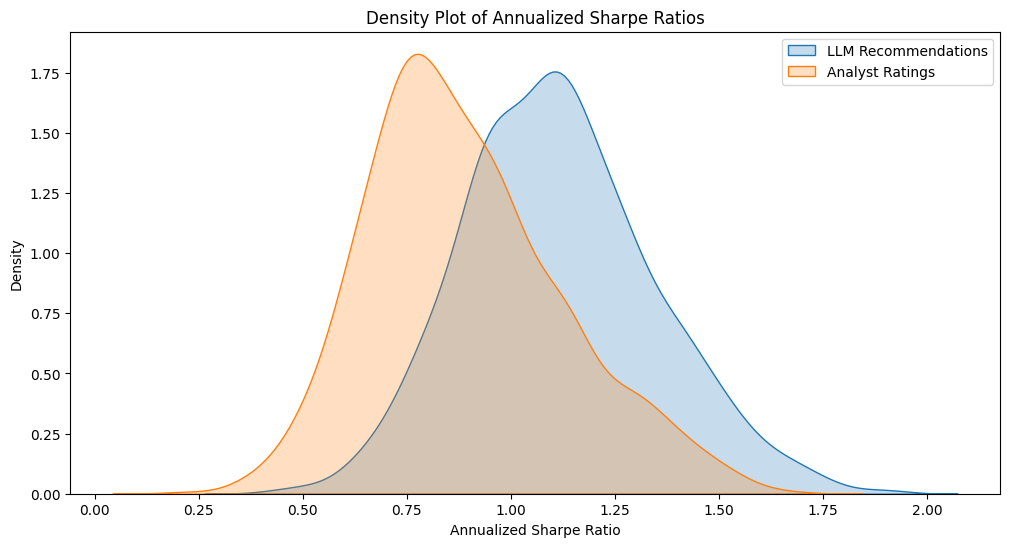

In [14]:
# Density plot of Sharpe Ratios
plt.figure(figsize=(12, 6))
sns.kdeplot(robustness_results_df["llm_sr"], label="LLM Recommendations", fill=True)
sns.kdeplot(robustness_results_df["analyst_sr"], label="Analyst Ratings", fill=True)
plt.title("Density Plot of Annualized Sharpe Ratios")
plt.xlabel("Annualized Sharpe Ratio")
plt.legend()
plt.show()

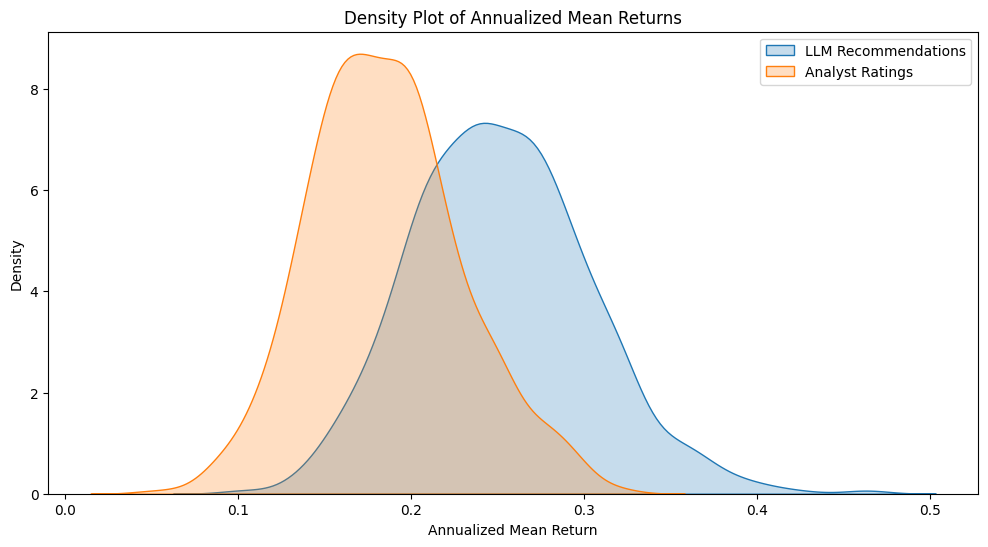

In [15]:
# Density plot of Mean Returns
plt.figure(figsize=(12, 6))
sns.kdeplot(robustness_results_df["llm_mean_ret"], label="LLM Recommendations", fill=True)
sns.kdeplot(robustness_results_df["analyst_mean_ret"], label="Analyst Ratings", fill=True)
plt.title("Density Plot of Annualized Mean Returns")
plt.xlabel("Annualized Mean Return")
plt.legend()
plt.show()

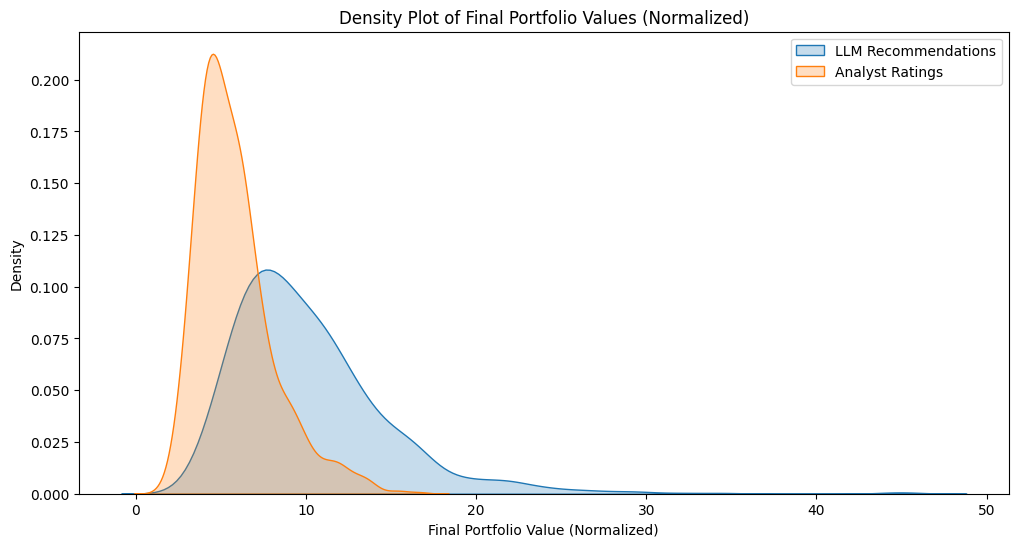

In [16]:
# Density plot of normalized final portfolio values
plt.figure(figsize=(12, 6))
sns.kdeplot(robustness_results_df["llm_final_val"], label="LLM Recommendations", fill=True)
sns.kdeplot(robustness_results_df["analyst_final_val"], label="Analyst Ratings", fill=True)
plt.title("Density Plot of Final Portfolio Values (Normalized)")
plt.xlabel("Final Portfolio Value (Normalized)")
plt.legend()
plt.show()